# Semantically segmented BEV

The goal is to compute semantically segmented(SS) BEV images using synthetic data from simulation.

The inputs are SS-ed images from vehicle-mounted cameras.

The desired output is SS-ed image in Bird's-eye-view.

###### Why BEV semantic maps?
In a typical autonomous driving stack, Behavior Prediction and Planning are generally done in this a top-down view (or bird’s-eye-view, BEV), as hight information is less important and most of the information an autonomous vehicle would need can be conveniently represented with BEV. This BEV space can be loosely referred to as the 3D space.

We can't use occupancy grid maps, cuz they run under the assumption that the environment is static(flat), which can lead to some a high drop in resolution, and high distortion of moving objects. it also does not provide of uncertainty for invisible areas.

credits: IEEE ITSC 2020 – Cam2BEV: Transforming Camera Images to a Semantically Segmented Bird's Eye View

![title](vision_stack.png)

The training is done over syntetic simulation data(cause its much more easier to generate labeled data in simulation platforms). And in order to reduce the 'reality gap', we use an intermediate representation based on SS-ed images of the real world and try to match it with the training data. thus deleting unimportant 'details' to our project.

##### Problem:(when it rains for example, the ss-ed image will not take rain in consideration, and the behavior of the agent will be the same in a non-rainy environment, which is not really appreciated)

The gap between the representation used in perception and downstream tasks such as prediction and planning are typically bridged in the Sensor Fusion stack, which lifts the 2D observation in perspective space to 3D or BEV, usually with the help of active sensors such as radar or lidar. That said, it is beneficial for perception across modalities to use BEV representation. First of all, it is interpretable and facilitates debugging about inherent failure modes for each sensing modality. It is also easily extensible to other new modalities and simplifies the task of late fusion. In addition, as mentioned above, the perception results in this representation can be readily consumed by prediction and planning stack.

In [3]:
import os
from os import listdir
from os.path import isfile, join
import sys
import numpy as np
import random
import tensorflow as tf
import cv2
import xml.etree.ElementTree as xmlET
from tqdm import tqdm
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg

from third_party.spatial_transformer import SpatialTransformer


In [4]:
#helper functions
def get_files_in_folder(folder):

    return sorted([os.path.join(folder, f) for f in os.listdir(folder)])



def sample_list(*ls, n_samples, replace=False):

    n_samples = min(len(ls[0]), n_samples)
    idcs = np.random.choice(np.arange(0, len(ls[0])), n_samples, replace=replace)
    samples = zip([np.take(l, idcs) for l in ls])
    return samples, idcs

def load_image(filename):

    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_module(module_file):

    name = os.path.splitext(os.path.basename(module_file))[0]
    dir = os.path.dirname(module_file)
    sys.path.append(dir)
    spec = importlib.util.spec_from_file_location(name, module_file)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    return module

def one_hot_encode_image(image, palette):

    one_hot_map = []

    # find instances of class colors and append layer to one-hot-map
    for class_colors in palette:
        class_map = np.zeros(image.shape[0:2], dtype=bool)
        for color in class_colors:
            class_map = class_map | (image == color).all(axis=-1)
        one_hot_map.append(class_map)

    # finalize one-hot-map
    one_hot_map = np.stack(one_hot_map, axis=-1)
    one_hot_map = one_hot_map.astype(np.float32)

    return one_hot_map

def one_hot_decode_image(one_hot_image, palette):

    # create empty image with correct dimensions
    height, width = one_hot_image.shape[0:2]
    depth = palette[0][0].size
    image = np.zeros([height, width, depth])

    # reduce all layers of one-hot-encoding to one layer with indices of the classes
    map_of_classes = one_hot_image.argmax(2)

    for idx, class_colors in enumerate(palette):
        # fill image with corresponding class colors
        image[np.where(map_of_classes == idx)] = class_colors[0]

    image = image.astype(np.uint8)

    return image

## Examples

<Figure size 432x288 with 0 Axes>

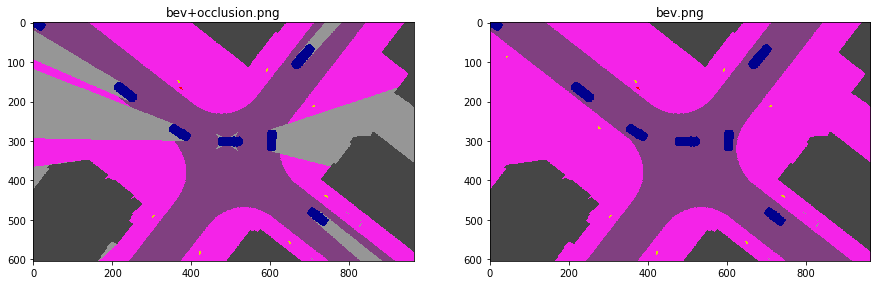

<Figure size 432x288 with 0 Axes>

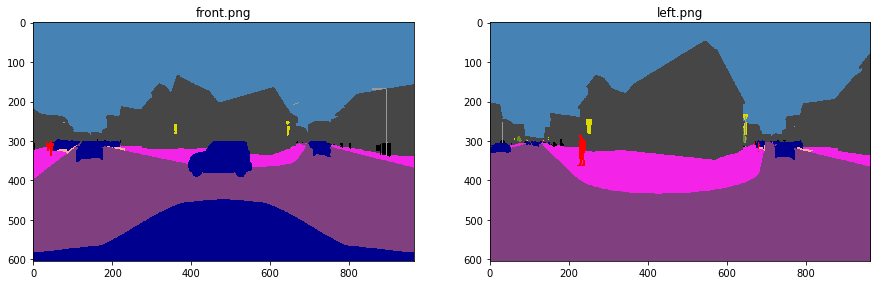

<Figure size 432x288 with 0 Axes>

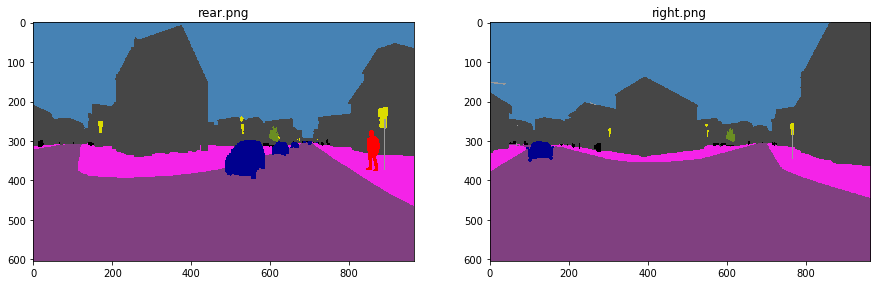

In [5]:
mypath= 'C:/Users/Monaim/Desktop/G3/Impact/Cam2Bev/cam2bev-data-master/cam2bev-data-master/1_FRLR/examples/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for i in range(0,6,2):
    Image1 = cv2.imread(mypath+onlyfiles[i]) 
    Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
    Image2 = cv2.imread(mypath+onlyfiles[i+1]) 
    Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)

    plt.figure()
    
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.title(onlyfiles[i])
    plt.imshow(Image1)
    
    plt.subplot(1,2,2)
    plt.title(onlyfiles[i+1])
    plt.imshow(Image2)
    plt.show()

In [6]:
def resize_image(img, shape, interpolation=cv2.INTER_CUBIC):

    # resize relevant image axis to length of corresponding target axis while preserving aspect ratio
    axis = 0 if float(shape[0]) / float(img.shape[0]) > float(shape[1]) / float(img.shape[1]) else 1
    factor = float(shape[axis]) / float(img.shape[axis])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor, interpolation=interpolation)

    # crop other image axis to match target shape
    center = img.shape[int(not axis)] / 2.0
    step = shape[int(not axis)] / 2.0
    left = int(center-step)
    right = int(center+step)
    if axis == 0:
        img = img[:, left:right]
    else:
        img = img[left:right, :]

    return img

def resize_image_op(img, fromShape, toShape, cropToPreserveAspectRatio=True, interpolation=tf.image.ResizeMethod.BICUBIC):

    if not cropToPreserveAspectRatio:
        img = tf.image.resize(img, toShape, method=interpolation)
        
    else:

        # first crop to match target aspect ratio
        fx = toShape[1] / fromShape[1]
        fy = toShape[0] / fromShape[0]
        relevantAxis = 0 if fx < fy else 1
        if relevantAxis == 0:
            crop = fromShape[0] * toShape[1] / toShape[0]
            img = tf.image.crop_to_bounding_box(img, 0, int((fromShape[1] - crop) / 2), fromShape[0], int(crop))
        else:
            crop = fromShape[1] * toShape[0] / toShape[1]
            img = tf.image.crop_to_bounding_box(img, int((fromShape[0] - crop) / 2), 0, int(crop), fromShape[1])

         # then resize to target shape
        img = tf.image.resize(img, toShape, method=interpolation)

    return img    


In [7]:
Image1.shape

(604, 964, 3)

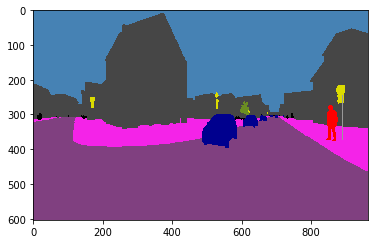

In [8]:
plt.imshow(Image1)

In [9]:
Image1.shape

(604, 964, 3)

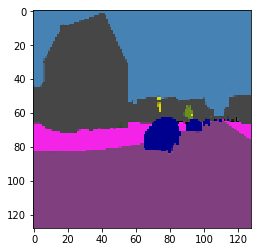

In [10]:
to_shape=(128,128,3)
img=resize_image(Image1, to_shape )
plt.imshow(img)

## Data preparation:

In [13]:
train_path ='C:/Users/Monaim/Desktop/G3/Impact/Cam2Bev/cam2bev-data-master/cam2bev-data-master/1_FRLR/train/'
valid_path = 'C:/Users/Monaim/Desktop/G3/Impact/Cam2Bev/cam2bev-data-master/cam2bev-data-master/1_FRLR/train/'

#training files
front_file = [f for f in listdir(train_path+'front/front/') if isfile(join(train_path+'front/front/', f))]
rear_file = [f for f in listdir(train_path+'rear/rear/') if isfile(join(train_path+'rear/rear/', f))]
right_file  = [f for f in listdir(train_path+'right/right/') if isfile(join(train_path+'right/right/', f))]
left_file = [f for f in listdir(train_path+'left/left/') if isfile(join(train_path+'left/left/', f))]

target_train= [f for f in listdir(train_path+'bev+occlusion/bev+occlusion') if isfile(join(train_path+'bev+occlusion/bev+occlusion', f))]

input_training= [front_file, rear_file, right_file, left_file]

#validation files
front_file_valid = [f for f in listdir(valid_path+'front/front/') if isfile(join(valid_path+'front/front/', f))]
rear_file_valid = [f for f in listdir(valid_path+'rear/rear/') if isfile(join(valid_path+'rear/rear/', f))]
right_file_valid  = [f for f in listdir(valid_path+'right/right/') if isfile(join(valid_path+'right/right/', f))]
left_file_valid = [f for f in listdir(valid_path+'left/left/') if isfile(join(valid_path+'left/left/', f))]

files_valid_input= front_file_valid+rear_file_valid+right_file_valid+left_file_valid

In [15]:
front_file[0]

't_0_0_0001000.png'

##### Pre-processing stack:

In [16]:
# sizes=[ cv2.imread(mypath+'front/front/'+str(front[i])).shape for i in len(front[:50])]
# cv2.imread(mypath+'front/front/'+str(front[3])).shape
# Imagefront = cv2.cvtColor(Imagefront, cv2.COLOR_BGR2RGB)
# Imagefront.shape

- input-training: \[../data/1_FRLR/train/front, /data/1_FRLR/train/rear, ../data/1_FRLR/train/left, ../data/1_FRLR/train/right]
- label-training: /data/1_FRLR/train/bev+occlusion
- max-samples-training: 100000
- input-validation: [../data/1_FRLR/val/front, ../data/1_FRLR/val/rear, ../data/1_FRLR/val/left, ../data/1_FRLR/val/right]
- label-validation: ../data/1_FRLR/val/bev+occlusion
- max-samples-validation: 10000

In [20]:
# get max_samples_training random training samples
n_inputs = 4 #len(input_training)
max_samples_training= 100000
max_samples_validation= 10000
image_shape = [256, 512]

files_train_input = front_file+rear_file+right_file+left_file
files_train_label = target_train

_, idcs = sample_list(files_train_label, max_samples_training, replace=False)
files_train_input = [np.take(f, idcs) for f in files_train_input]
files_train_label = np.take(files_train_label, idcs)
image_shape_original_input = load_image(files_train_input[0][0]).shape[0:2]
image_shape_original_label = load_image(files_train_label[0]).shape[0:2]
print(f"Found {len(files_train_label)} training samples")


Found 33199 training samples


## Training

In [23]:
# load uNetXST architecture module
architecture = load_module("uNetXST_Architecture.py")


In [35]:
batch_size = 5    #the number of samples processed before the model is updated.
epochs= 100 # the number of complete passes through the training dataset.
# unetxst-homographies= "../preprocessing/homography_converter/uNetXST_homographies/2_F.py"
learning_rate= 0.0001
loss_weights= [1.00752063, 5.06392476, 1.15378408, 1.16118375]
n_inputs = len(files_train_input)
one_hot_palette_input = "one_hot_conversion/convert_10.xml"
one_hot_palette_label = "one_hot_conversion/convert_9+occl.xml"
image_shape = [256, 512]
loss_weights: [0.98684351, 2.2481491, 10.47452063, 4.78351389, 7.01028204, 8.41360361, 10.91633349, 2.38571558, 1.02473193, 2.79359197]
early_stopping_patience= 20
save_interval= 5
class_names= ['road', 'sidewalk', 'person', 'car', 'truck', 'bus', 'bike', 'obstacle', 'vegetation', 'occluded']
output_dir= 'C:/Users/Monaim/Desktop/G3/Impact/Cam2Bev/cam2bev-data-master/cam2bev-data-master/1_FRLR/train/output'


# build training data pipeline
dataTrain = tf.data.Dataset.from_tensor_slices((tuple(files_train_input), files_train_label))
dataTrain = dataTrain.shuffle(buffer_size=max_samples_training, reshuffle_each_iteration=True)
dataTrain = dataTrain.map(parse_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataTrain = dataTrain.batch(batch_size, drop_remainder=True)
dataTrain = dataTrain.repeat(epochs)
dataTrain = dataTrain.prefetch(1)
print("Built data pipeline for training")

# build validation data pipeline
dataValid = tf.data.Dataset.from_tensor_slices((tuple(files_valid_input), files_valid_label))
dataValid = dataValid.map(parse_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataValid = dataValid.batch(1)
dataValid = dataValid.repeat(cepochs)
dataValid = dataValid.prefetch(1)
print("Built data pipeline for validation")


def parse_sample(input_files, label_file):
    # parse and process input images
    inputs = []
    for inp in input_files:
        inp = utils.load_image(inp)
        inp = resize_image(inp, image_shape_original_input, image_shape, interpolation=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        inp = one_hot_encode_image(inp, one_hot_palette_input)
        inputs.append(inp)
    inputs = inputs[0] if n_inputs == 1 else tuple(inputs)
    # parse and process label image
    label = utils.load_image(label_file)
    label = utils.resize_image(label, image_shape_original_label, image_shape, interpolation=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = utils.one_hot_encode_image(label, one_hot_palette_label)
    return inputs, label

# build model
if unetxst_homographies is not None:
  uNetXSTHomographies = load_module(unetxst_homographies)
  model = architecture.get_network((image_shape[0], image_shape[1], n_classes_input), n_classes_label, n_inputs=n_inputs, thetas=uNetXSTHomographies.H)
else:
  model = architecture.get_network((image_shape[0], image_shape[1], n_classes_input), n_classes_label)
if conf.model_weights is not None:
  model.load_weights(model_weights)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
if loss_weights is not None:
    loss = weighted_categorical_crossentropy(loss_weights)
else:
    loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy(), utils.MeanIoUWithOneHotLabels(num_classes=n_classes_label)]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
print(f"Compiled model {os.path.basename(model)}")


# create output directories
model_output_dir = os.path.join(output_dir, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
tensorboard_dir = os.path.join(model_output_dir, "TensorBoard")
checkpoint_dir  = os.path.join(model_output_dir, "Checkpoints")
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

    
# start training
print("Starting training...")
n_batches_train = len(files_train_label) // batch_size"
n_batches_valid = len(files_valid_label)
model.fit(dataTrain,
          epochs=conf.epochs, steps_per_epoch=n_batches_train,
          validation_data=dataValid, validation_freq=1, validation_steps=n_batches_valid,
          callbacks=callbacks)

Starting training...
